# 策略回测框架
### 1. 简单回测
### 2. 函数封装
### 3. 常用回测框架介绍

# 1.简单回测
策略回测类似于单因子测试， 仅仅使用固定周期的股票持仓来获取该周期的收益，从而获取整体收益

## 1.1 读取数据
这里我直接从本地读取数据，行情数据来源于实习公司
如果没有现成的数据的话可以从tushare（ https://tushare.pro ）中读取行情、财务或者部分常用因子数据（学生可以免费获取几乎所有数据权限）

In [4]:
import tushare as ts
ts.set_token('2e2c63d79c07d8f2cd100e087b96921eae394d582b75de9e8fdc5277')
pro = ts.pro_api()
df = ts.pro_bar(pro_api=pro,ts_code='000001.SZ', adj='qfq', start_date='20180101', end_date='20181011')

('Connection aborted.', error(54, 'Connection reset by peer'))


In [138]:
import pandas as pd 

factor = pd.read_csv("stock_pred_prob_120.csv",index_col = 0) #读取单个因子数据

In [2]:
import scipy.io

mkt_data = scipy.io.loadmat('Market_data_all_20190831.mat')

In [3]:
#读取时间列表
date_list = mkt_data["row_days"].T[0]
date_list = [a for a in date_list if a > 20100101 and a < 20190101] 
date_list.sort()

In [7]:
#读取股票列表
stock_list  = []
for i in range(len(mkt_data["column_stock"].tolist()[0])):
    stock_list.append(mkt_data["column_stock"].tolist()[0][i].tolist()[0])

In [208]:
#将行情数据中的指数成分股数据转化dataframe
def get_index_stock(index_name):
    index_stock = pd.DataFrame(mkt_data[index_name])
    index_stock.index = mkt_data["row_days"].T[0]
    index_stock.columns = stock_list
    return index_stock.loc[date_list]

#获取中证500的股票池
index_stock = get_index_stock("zz500pool")

#读取股票收益数据
stock_return = pd.DataFrame(mkt_data["stk_price_info"][0][0][0],index = mkt_data["row_days"].T[0],columns = stock_list)
stock_return = stock_return.loc[date_list]

#读取是否交易和ST股票数据
istrade = pd.DataFrame(mkt_data["stk_price_info"][0][0][5],index = mkt_data["row_days"].T[0],columns = stock_list).loc[date_list]
isst = pd.DataFrame(mkt_data["stk_price_info"][0][0][6],index = mkt_data["row_days"].T[0],columns = stock_list).loc[date_list]

In [11]:
#读取股票行情数据
stock_price_low = pd.DataFrame(mkt_data['stk_price_info'][0][0][1],index = mkt_data["row_days"].T[0],
                                     columns = stock_list).loc[date_list,stock_list]
stock_price_high = pd.DataFrame(mkt_data['stk_price_info'][0][0][2],index = mkt_data["row_days"].T[0],
                                      columns = stock_list).loc[date_list,stock_list]
stock_price_close = pd.DataFrame(mkt_data['stk_price_info'][0][0][3],index = mkt_data["row_days"].T[0],
                                       columns = stock_list).loc[date_list,stock_list]
stock_price_open = pd.DataFrame(mkt_data['stk_price_info'][0][0][4],index = mkt_data["row_days"].T[0],
                                      columns = stock_list).loc[date_list,stock_list]
split_adjusted = pd.DataFrame(mkt_data['stk_price_info'][0][0][8],index = mkt_data["row_days"].T[0],
                              columns = stock_list).loc[date_list,stock_list]

stock_price_low =  split_adjusted * stock_price_low
stock_price_high = split_adjusted * stock_price_high
stock_price_close = split_adjusted * stock_price_close
stock_price_open = split_adjusted * stock_price_open

## 1.2 计算每个周期的收益率
（1）因子是日频日子，所以按照每天来计算收益率，但是要注意计算因子通常是在当天收盘之后，所以因子的收益率是后一天的收益率  
（2）步骤：根据因子确定股票池->计算股票池权重->计算股票池收益率

In [151]:
import time
factor = factor.shift(1)[1:] #将因子表整体向下平移一格，用来表示计算因子收益率应当用后一天的收益
start_time = time.time()
port_return = []
for date in factor.index:
    sort_fac = factor.loc[date].sort_values(ascending = False) #将因子按照从大到小排序
    port_stock = sort_fac[:100].index.tolist() #取因子最大前100个股票
    port_weight = pd.Series(1./len(port_stock),index = port_stock) #分配每个股票的权重，等权
    port_return_day  = (port_weight * stock_return.loc[date,port_weight.index]).sum() #计算股票池收益率
    port_return.append(port_return_day) #将当天收益率添加到收益率列表中
port_return = pd.Series(port_return,index = factor.index) #将列表数据转化成series格式，index是日期序列
end_time = time.time()
print ("time used:",(end_time - start_time))
port_return

('time used:', 5.318649768829346)


20100706    0.032730
20100707    0.017628
20100708    0.002709
20100709    0.038416
20100712    0.019103
20100713   -0.013029
20100714    0.021203
20100715   -0.020154
20100716    0.008514
20100719    0.028087
20100720    0.035658
20100721    0.007946
20100722    0.021153
20100723    0.001895
20100726    0.020387
20100727    0.008104
20100728    0.025385
20100729    0.013396
20100730    0.002890
20100802    0.024156
20100803   -0.008219
20100804    0.009568
20100805    0.012515
20100806    0.023933
20100809    0.018180
20100810   -0.033756
20100811    0.014084
20100812   -0.009605
20100813    0.024987
20100816    0.023227
              ...   
20181116    0.010258
20181119    0.009084
20181120   -0.022321
20181121    0.024560
20181122    0.007195
20181123   -0.047935
20181126    0.007740
20181127    0.014037
20181128    0.021817
20181129   -0.019212
20181130    0.020600
20181203    0.035591
20181204    0.020469
20181205   -0.003645
20181206   -0.007499
20181207    0.007990
20181210   -0

In [237]:
#利用表操作提升运算速度
import numpy as np
start_time = time.time()

min_fac = np.sort(factor.values*-1,axis = 1)[:,100]*-1 #取每一行排序后的的第100个值
port_weight = (factor.T >  min_fac).T #每一行比第100个值大的为TRUE，由于dataframe会自动用每一列和数组进行比较所以需要转置
port_weight = port_weight/100. #等权重设置

port_return = (port_weight * stock_return.loc[port_weight.index,port_weight.columns]).sum(axis = 1)#计算收益率
end_time = time.time()
print ("time used:",(end_time - start_time))
port_return

('time used:', 1.7250890731811523)


20100706    0.032730
20100707    0.017628
20100708    0.002709
20100709    0.038416
20100712    0.019103
20100713   -0.013029
20100714    0.021203
20100715   -0.020154
20100716    0.008514
20100719    0.028087
20100720    0.035658
20100721    0.007946
20100722    0.021153
20100723    0.001895
20100726    0.020387
20100727    0.008104
20100728    0.025385
20100729    0.013396
20100730    0.002890
20100802    0.024156
20100803   -0.008219
20100804    0.009568
20100805    0.012515
20100806    0.023933
20100809    0.018180
20100810   -0.033756
20100811    0.014084
20100812   -0.009605
20100813    0.024987
20100816    0.023227
              ...   
20181116    0.010258
20181119    0.009084
20181120   -0.022321
20181121    0.024560
20181122    0.007195
20181123   -0.047935
20181126    0.007740
20181127    0.014037
20181128    0.021817
20181129   -0.019212
20181130    0.020600
20181203    0.035591
20181204    0.020469
20181205   -0.003645
20181206   -0.007500
20181207    0.007990
20181210   -0

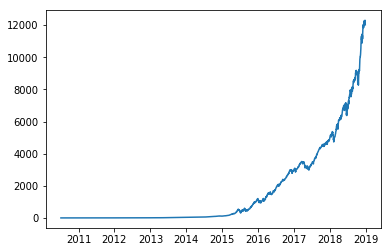

In [156]:
from matplotlib import pyplot as plt
import datetime 
cum_port_return = (port_return + 1).cumprod()
plt.figure()
x_plot = [datetime.datetime.strptime(str(d), '%Y%m%d').date() for d in cum_port_return.index]
plt.plot(x_plot,cum_port_return)
plt.show()
plt.close()

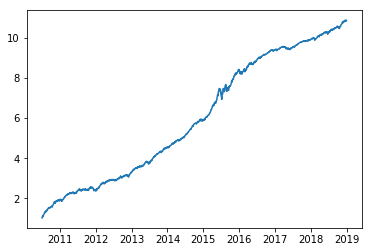

In [157]:
cum_port_return = port_return.cumsum() + 1
plt.figure()
x_plot = [datetime.datetime.strptime(str(d), '%Y%m%d').date() for d in cum_port_return.index]
plt.plot(x_plot,cum_port_return)
plt.show()

（3）扣除交易费用

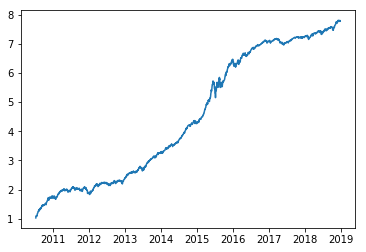

In [193]:
BP = 0.0001
#计算两期的权重差异之和，权重差异的绝对值为调仓权重占总权重的比例
port_weight_change = (port_weight - port_weight.shift(1)).abs().sum(axis = 1)
port_weight_change.iloc[0] = 1.
port_return_tran  = port_return - port_weight_change*10*BP
cum_port_return = port_return_tran.cumsum() + 1
plt.figure()
x_plot = [datetime.datetime.strptime(str(d), '%Y%m%d').date() for d in cum_port_return.index]
plt.plot(x_plot,cum_port_return)
plt.show()

(5)通常需要和股指进行对冲，对冲掉市场（beta）风险

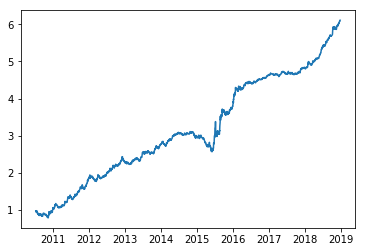

In [200]:
index_stock = index_stock.replace(0,np.nan)
benchmark  = (index_stock * stock_return.loc[index_stock.index,index_stock.columns]).mean(axis = 1,skipna  = True)
port_return_tran = port_return_tran - benchmark[port_return_tran.index]

cum_port_return = port_return_tran.cumsum() + 1
plt.figure()
x_plot = [datetime.datetime.strptime(str(d), '%Y%m%d').date() for d in cum_port_return.index]
plt.plot(x_plot,cum_port_return)
plt.show()

## 1.3 计算相关回测指标

In [202]:
def MaxDrawdown(df,cal_type = 0):
    '''最大回撤率'''
    if cal_type  == 0:
        df = (df + 1).cumprod()
    elif cal_type == 1:
        df = df.cumsum() + 1
    j = np.argmax((np.maximum.accumulate(df.values) - df.values))# 结束位置
    if j == 0:
        return 0
    i = np.argmax(df.values[:j])  # 开始位置
    return (df.values[i] - df.values[j]) / (df.values[i])*100,df.index[i],df.index[j]
def annualized_return(df,cal_type = 0):
    '''年化收益率'''
    if cal_type == 0:
        df = (df + 1).cumprod() 
        return (df.values[-1]**(260./float(len(df))) - 1)*100
    elif cal_type == 1:
        return df.mean()*250*100
def annualized_volatility(df):
    '''年化波动率'''
    return (260.**0.5*df.std(ddof = 1))*100
def port_IR(df,cal_type = 0):
    if (cal_type == 0):
        return annualized_return(df)/annualized_volatility(df)
    elif (cal_type == 1):
        return annualized_return(df,1)/annualized_volatility(df)

In [207]:
print ("MaxDrawdown:",MaxDrawdown(port_return_tran,cal_type = 1))
print ("annualized_return:",annualized_return(port_return_tran,cal_type = 1))
print ("annualized_volatility:",annualized_volatility(port_return_tran))
print ("port_IR:",port_IR(port_return_tran,cal_type = 1))

('MaxDrawdown:', (17.500098386985982, 20141023, 20150602))
('annualized_return:', 61.845802179093553)
('annualized_volatility:', 31.311257232156219)
('port_IR:', 1.9751938327017666)


## 1.4 常需要注意的点
（1）无法交易的股票

In [281]:
#port_weight_temp = port_weight.copy()
port_weight = port_weight_temp.copy()

In [282]:
#一字板
A = ((stock_price_high / stock_price_close.shift(1) -1) < -0.0985)
B = ((stock_price_low / stock_price_close.shift(1) -1) > 0.0985)
#停牌
C = (istrade == 0)
#ST
D = (isst == 1)
not_trade = (A | B | C).replace(0,np.nan)[port_weight.columns] #统一股票列表
not_buy = D.replace(0,np.nan)[port_weight.columns] #统一股票列表

for ii in range(len(port_weight.index)):
    not_trade_day = not_trade.loc[date].dropna() #选取无法交易的股票列表
    not_buy_day = not_buy.loc[date].dropna() #选取不要买入的股票列表
    if ii == 0:
        date = port_weight.index[ii]
        port_weight.loc[date,not_trade_day] = 0. 
        port_weight.loc[date,not_buy_day] = 0.
        port_weight.loc[date] = port_weight.loc[date]/port_weight.loc[date].sum() 
    else:
        date  = port_weight.index[ii]
        last_date = port_weight.index[ii-1]
        port_weight.loc[date,not_trade_day] = port_weight.loc[last_date,not_trade_day] #无法交易的股票沿用上一期的权重
        port_weight.loc[date,not_buy_day] = 0.
        res_weight = 1 - port_weight.loc[last_date,not_trade_day].sum()
        trade_day = list(set(port_weight.columns.tolist()) - set(not_trade_day))
        port_weight.loc[date,trade_day] = port_weight.loc[date,trade_day] * res_weight
port_weight.sum(axis = 1)

20100706    1.000000
20100707    1.000000
20100708    0.999600
20100709    0.999616
20100712    1.000000
20100713    1.000000
20100714    0.999900
20100715    1.000000
20100716    0.999100
20100719    0.999906
20100720    0.999902
20100721    1.000000
20100722    0.999900
20100723    1.000000
20100726    0.999100
20100727    0.999906
20100728    1.000000
20100729    0.999900
20100730    0.998432
20100802    1.000000
20100803    1.000000
20100804    1.000000
20100805    1.000000
20100806    1.000000
20100809    0.999600
20100810    0.999616
20100811    0.997635
20100812    0.998622
20100813    0.999293
20100816    0.998732
              ...   
20181116    0.999914
20181119    0.999916
20181120    0.999918
20181121    0.999919
20181122    0.989834
20181123    0.999923
20181126    0.999925
20181127    0.999926
20181128    0.989844
20181129    0.989851
20181130    0.999932
20181203    0.999934
20181204    0.999935
20181205    0.999936
20181206    0.999937
20181207    0.999938
20181210    0

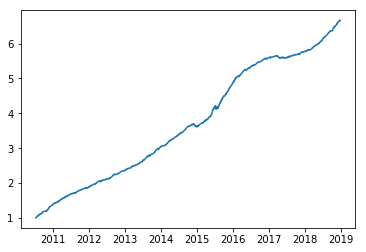

In [283]:
port_return = (port_weight * stock_return.loc[port_weight.index,port_weight.columns]).sum(axis = 1)#计算收益率
port_weight_change = (port_weight - port_weight.shift(1)).abs().sum(axis = 1)
port_weight_change.iloc[0] = 1.
port_return_tran  = port_return - port_weight_change*10*BP
port_return_tran = port_return_tran - benchmark[port_return_tran.index]

cum_port_return = port_return_tran.cumsum() + 1
plt.figure()
x_plot = [datetime.datetime.strptime(str(d), '%Y%m%d').date() for d in cum_port_return.index]
plt.plot(x_plot,cum_port_return)
plt.show()

（2）股票权重的变化   
当天目标股票权重交易之后，经过一天的交易，权重会发生一定的变化，导致有一些股票沿用上一期权重会出现问题
需要将股票的权重更新之后再进行收益率的计算，具体的处理方式是将一天的收益率分成两段，第一段为前一天收盘到当天开盘，第二段为当天开盘到当天收盘

In [293]:
date_list_ = factor.index.tolist() 
port_return = pd.Series(index = date_list_)
turnover_rate = pd.Series(index = date_list_)
last_weight = pd.Series([0]*len(factor.columns),index = factor.columns)
for date in date_list_:
    today_date_index = date_list_.index(date)
    sort_fac = factor.loc[date].sort_values(ascending = False) #将因子按照从大到小排序
    port_stock = sort_fac[:100].index.tolist() #取因子最大前100个股票
    port_weight = pd.Series(index = factor.columns)
    port_weight[port_stock] = 1./len(port_stock) #分配每个股票的权重，等权
    if date == date_list_[0]: #对于第一期
        new_weight = port_weight #当天的股票池权重就是目标权重
        turnover_rate[date] = ((new_weight.fillna(0)-last_weight.fillna(0)).abs().sum())*100 #计算换手率
        #计算收盘时权重
        close_weight = new_weight *  (stock_price_close.loc[date,new_weight.index]/stock_price_open.loc[date,new_weight.index])  
        transacton_cost = turnover_rate[date]/100 * 10 * BP
        port_return[date] = close_weight.sum() - 1 - transacton_cost
        last_weight = close_weight/close_weight.sum()
    else:
        last_date = date_list_[today_date_index-1] 
        #计算开盘时权重，由上一期权重乘以价格跳空得到
        open_weight = last_weight * (stock_price_open.loc[date,last_weight.index])/ (stock_price_close.loc[last_date,last_weight.index])
        open_weight_sum  = open_weight.sum()
        #将目标权重调整为跳空后总的权重
        new_weight = port_weight*open_weight_sum
        turnover_rate[date] = ((new_weight.fillna(0)-open_weight.fillna(0)).abs().sum())/open_weight_sum * 100 / 2
        close_weight = new_weight *  (stock_price_close.loc[date,new_weight.index]/stock_price_open.loc[date,new_weight.index])
        transacton_cost = turnover_rate[date]/100 * 10 * BP
        port_return[date] = close_weight.sum() - 1 - transacton_cost
        last_weight = close_weight/close_weight.sum()
port_return

20100706    0.033279
20100707    0.018130
20100708    0.001292
20100709    0.036282
20100712    0.018190
20100713   -0.014457
20100714    0.019322
20100715   -0.020590
20100716    0.004741
20100719    0.026646
20100720    0.036997
20100721    0.006679
20100722    0.020167
20100723    0.001584
20100726    0.019118
20100727    0.006994
20100728    0.023654
20100729    0.012384
20100730    0.001752
20100802    0.023434
20100803   -0.009327
20100804    0.008272
20100805    0.010873
20100806    0.022141
20100809    0.016814
20100810   -0.035348
20100811    0.013556
20100812   -0.011491
20100813    0.022511
20100816    0.022475
              ...   
20181116    0.009294
20181119    0.008018
20181120   -0.023109
20181121    0.020373
20181122    0.006962
20181123   -0.049383
20181126    0.006587
20181127    0.011672
20181128    0.016017
20181129   -0.023307
20181130    0.016945
20181203    0.038326
20181204    0.018785
20181205   -0.007402
20181206   -0.008738
20181207    0.004897
20181210   -0

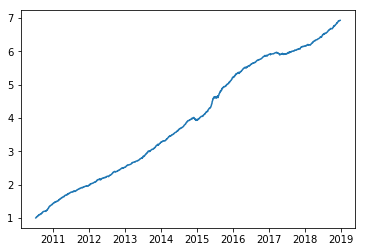

In [294]:
port_return_ab = port_return - benchmark[port_return_tran.index]

cum_port_return = port_return_ab.cumsum() + 1
plt.figure()
x_plot = [datetime.datetime.strptime(str(d), '%Y%m%d').date() for d in cum_port_return.index]
plt.plot(x_plot,cum_port_return)
plt.show()

# 2 函数封装

# 3. 常用回测框架

Zipline(https://github.com/quantopian/zipline) :拥有最大的社区，语法清晰，易于掌握，主要用于美股市场，回测速度较慢  
PyAlgoTrade(https://github.com/gbeced/pyalgotrade) :速度较快，较为灵活，不支持 Pandas  
vnpy(https://www.vnpy.com) :起源于国内私募的自主量化交易系统。支持大量交易接口，可以通过图形界面进行操作，策略扩展性高  
RiceQuant、JoinQuant、Uqer: 国内量化平台，比较类似，支持python读取和处理数据，并且提供API进行回测。看不到具体回测代码，多为个人投资者使用。  
特点：事件驱动回测平台

（1）事件模块  
事件模块包括一个事件的基类，在事件的基类下面则有很多子事件，如市场数据事件(market)、交易信号事件(signal)、委托下单事件(order)和订单成交事件(fill)等。此外，还需要一个事件队列来存储和管理所有子事件。  
（2）数据采集模块  
数据采集模块可以通过接口获取现在的行情数据和历史数据，该模块能够产生市场数据事件。历史数据的获取能直接读取我们搭建好的数据库，而实时的行情数据可能需要用到交易软件的接口。  
（3）策略模块  
策略模块与简单回测系统类似，输入bar或者tick数据，生成signal；策略模块可以产生信号事件。  
（4）交易执行模块  
交易执行模块接收信号事件，决定需要开仓和平仓的头寸数量，输出委托下单事件。该模块再根据委托下单事件进行模拟或者真实的交易，当订单成交事件完成时更新持有资产头寸以及其他相关数据。  
（5）资产头寸模块  
资产追踪模块贯穿于各个事件之间，它记录资金、仓位、仓位市值等信息。一旦发生了仓位的变动，那么资产头寸模块记录的各种数据将会更新。资产头寸模块的另一个作用是tracing策略执行的全过程，因此会记录所有的交易历史讯息。  
（6）事件队列  
在回测系统中，所有事件通过事件队列进行管理。当一个事件完成其使命后，就会自觉排到队伍最后，由下一个事件开始它的任务，如此循环。  